In [ ]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from IPython.display import Markdown, display
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Descargar stopwords en español
nltk.download('stopwords')

# Cargar la base de datos
df = pd.read_csv('sample_data/driver_data_with_messages_fe.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



# 1. Revisión y Comprensión del Dataset

- **Estructura y Heterogeneidad:**
    - *Objetivo:* Verificar la integración de variables numéricas, categóricas y textuales.
    - *Lo que se espera encontrar:* Una estructura consistente, sin errores evidentes y con las variables correctamente identificadas.
- **Calidad de los Datos:**
    - *Objetivo:* Evaluar la presencia de duplicados, errores y valores faltantes.
    - *Lo que se espera encontrar:* Información sobre la integridad del dataset y áreas que requieran limpieza.

In [ ]:
# Mostrar dimensiones, primeras filas, información y resumen estadístico
print("Dimensiones del dataset:", df.shape)
display(df.head(2))
print("\nInformación del dataset:")
df.info()
print("\nResumen estadístico de variables numéricas:")
display(df.describe())
print("\nValores faltantes por columna:")
display(df.isnull().sum())

Dimensiones del dataset: (3000, 18)


driver_id               tag  age  salary   education marital_status  \
0    3571958       operaciones   48    7390    primaria        soltero   
1    3880410  recursos humanos   30    5444  secundaria         casado   

   years_experience  num_prev_employers  trip_duration  distance_traveled  \
0                10                   4             30          16.445845   
1                 3                   2            159           6.584746   

  risk_zone  high_prob_leave  \
0      baja                0   
1      alta                0   

                                             message  salario_por_km  \
0  Hola, me gustaría que revisaran mi salario, ya...      449.326288   
1  Con un salario de 5444 pesos y viajes de casi ...      826.633723   

   experiencia_normalizada  salario_por_duracion  is_solo_provider  \
0                 0.208333            246.325122                 0   
1                 0.100000             34.238778                 0   

   zona_alta_y_sueldo_bajo  
0                        0  
1                        0


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   driver_id                3000 non-null   int64  
 1   tag                      3000 non-null   object 
 2   age                      3000 non-null   int64  
 3   salary                   3000 non-null   int64  
 4   education                3000 non-null   object 
 5   marital_status           3000 non-null   object 
 6   years_experience         3000 non-null   int64  
 7   num_prev_employers       3000 non-null   int64  
 8   trip_duration            3000 non-null   int64  
 9   distance_traveled        3000 non-null   float64
 10  risk_zone                3000 non-null   object 
 11  high_prob_leave          3000 non-null   int64  
 12  message                  3000 non-null   object 
 13  salario_por_km           3000 non-null   float64
 14

driver_id          age       salary  years_experience  \
count  3.000000e+03  3000.000000  3000.000000       3000.000000   
mean   3.700840e+06    39.445667  4957.505667         10.610000   
std    1.452874e+05    11.283712  1745.211969          9.132636   
min    3.450215e+06    20.000000  2001.000000          0.000000   
25%    3.576066e+06    30.000000  3404.750000          3.000000   
50%    3.700752e+06    39.000000  4970.500000          8.000000   
75%    3.825435e+06    49.000000  6469.250000         16.000000   
max    3.949961e+06    59.000000  7999.000000         40.000000   

       num_prev_employers  trip_duration  distance_traveled  high_prob_leave  \
count         3000.000000    3000.000000        3000.000000      3000.000000   
mean             1.994333      95.911333          50.494705         0.189333   
std              1.406044      48.436242          28.264764         0.391838   
min              0.000000      10.000000           1.032686         0.000000   
25%              1.000000      55.000000          26.943120         0.000000   
50%              2.000000      97.000000          50.345184         0.000000   
75%              3.000000     136.000000          74.114489         0.000000   
max              4.000000     179.000000          99.969788         1.000000   

       salario_por_km  experiencia_normalizada  salario_por_duracion  \
count     3000.000000              3000.000000           3000.000000   
mean       220.919096                 0.244323             83.294961   
std        422.223782                 0.175977             92.431174   
min         20.212604                 0.000000             11.931360   
25%         63.457934                 0.090909             32.922120   
50%         99.506901                 0.220169             52.487877   
75%        188.684755                 0.384615             92.714304   
max       6146.323521                 0.677966            777.522248   

       is_solo_provider  zona_alta_y_sueldo_bajo  
count       3000.000000              3000.000000  
mean           0.084667                 0.117667  
std            0.278431                 0.322267  
min            0.000000                 0.000000  
25%            0.000000                 0.000000  
50%            0.000000                 0.000000  
75%            0.000000                 0.000000  
max            1.000000                 1.000000


Valores faltantes por columna:


driver_id                  0
tag                        0
age                        0
salary                     0
education                  0
marital_status             0
years_experience           0
num_prev_employers         0
trip_duration              0
distance_traveled          0
risk_zone                  0
high_prob_leave            0
message                    0
salario_por_km             0
experiencia_normalizada    0
salario_por_duracion       0
is_solo_provider           0
zona_alta_y_sueldo_bajo    0
dtype: int64


# 2. Análisis de Variables Relacionadas con Conductores


- **Datos Demográficos y de Uso:**
    - *Objetivo:* Analizar variables como edad, antigüedad, número de viajes, etc.
    - *Lo que se espera encontrar:* Diferencias significativas entre conductores con alta y baja probabilidad de renunciar.
- **Comportamiento de los Conductores:**
    - *Objetivo:* Evaluar patrones de uso y desempeño.
    - *Lo que se espera encontrar:* Indicadores de comportamientos atípicos o señales de posible abandono.


Columnas numéricas detectadas: ['age', 'salary', 'years_experience', 'num_prev_employers', 'trip_duration', 'distance_traveled', 'high_prob_leave', 'salario_por_km', 'experiencia_normalizada', 'salario_por_duracion', 'is_solo_provider', 'zona_alta_y_sueldo_bajo']


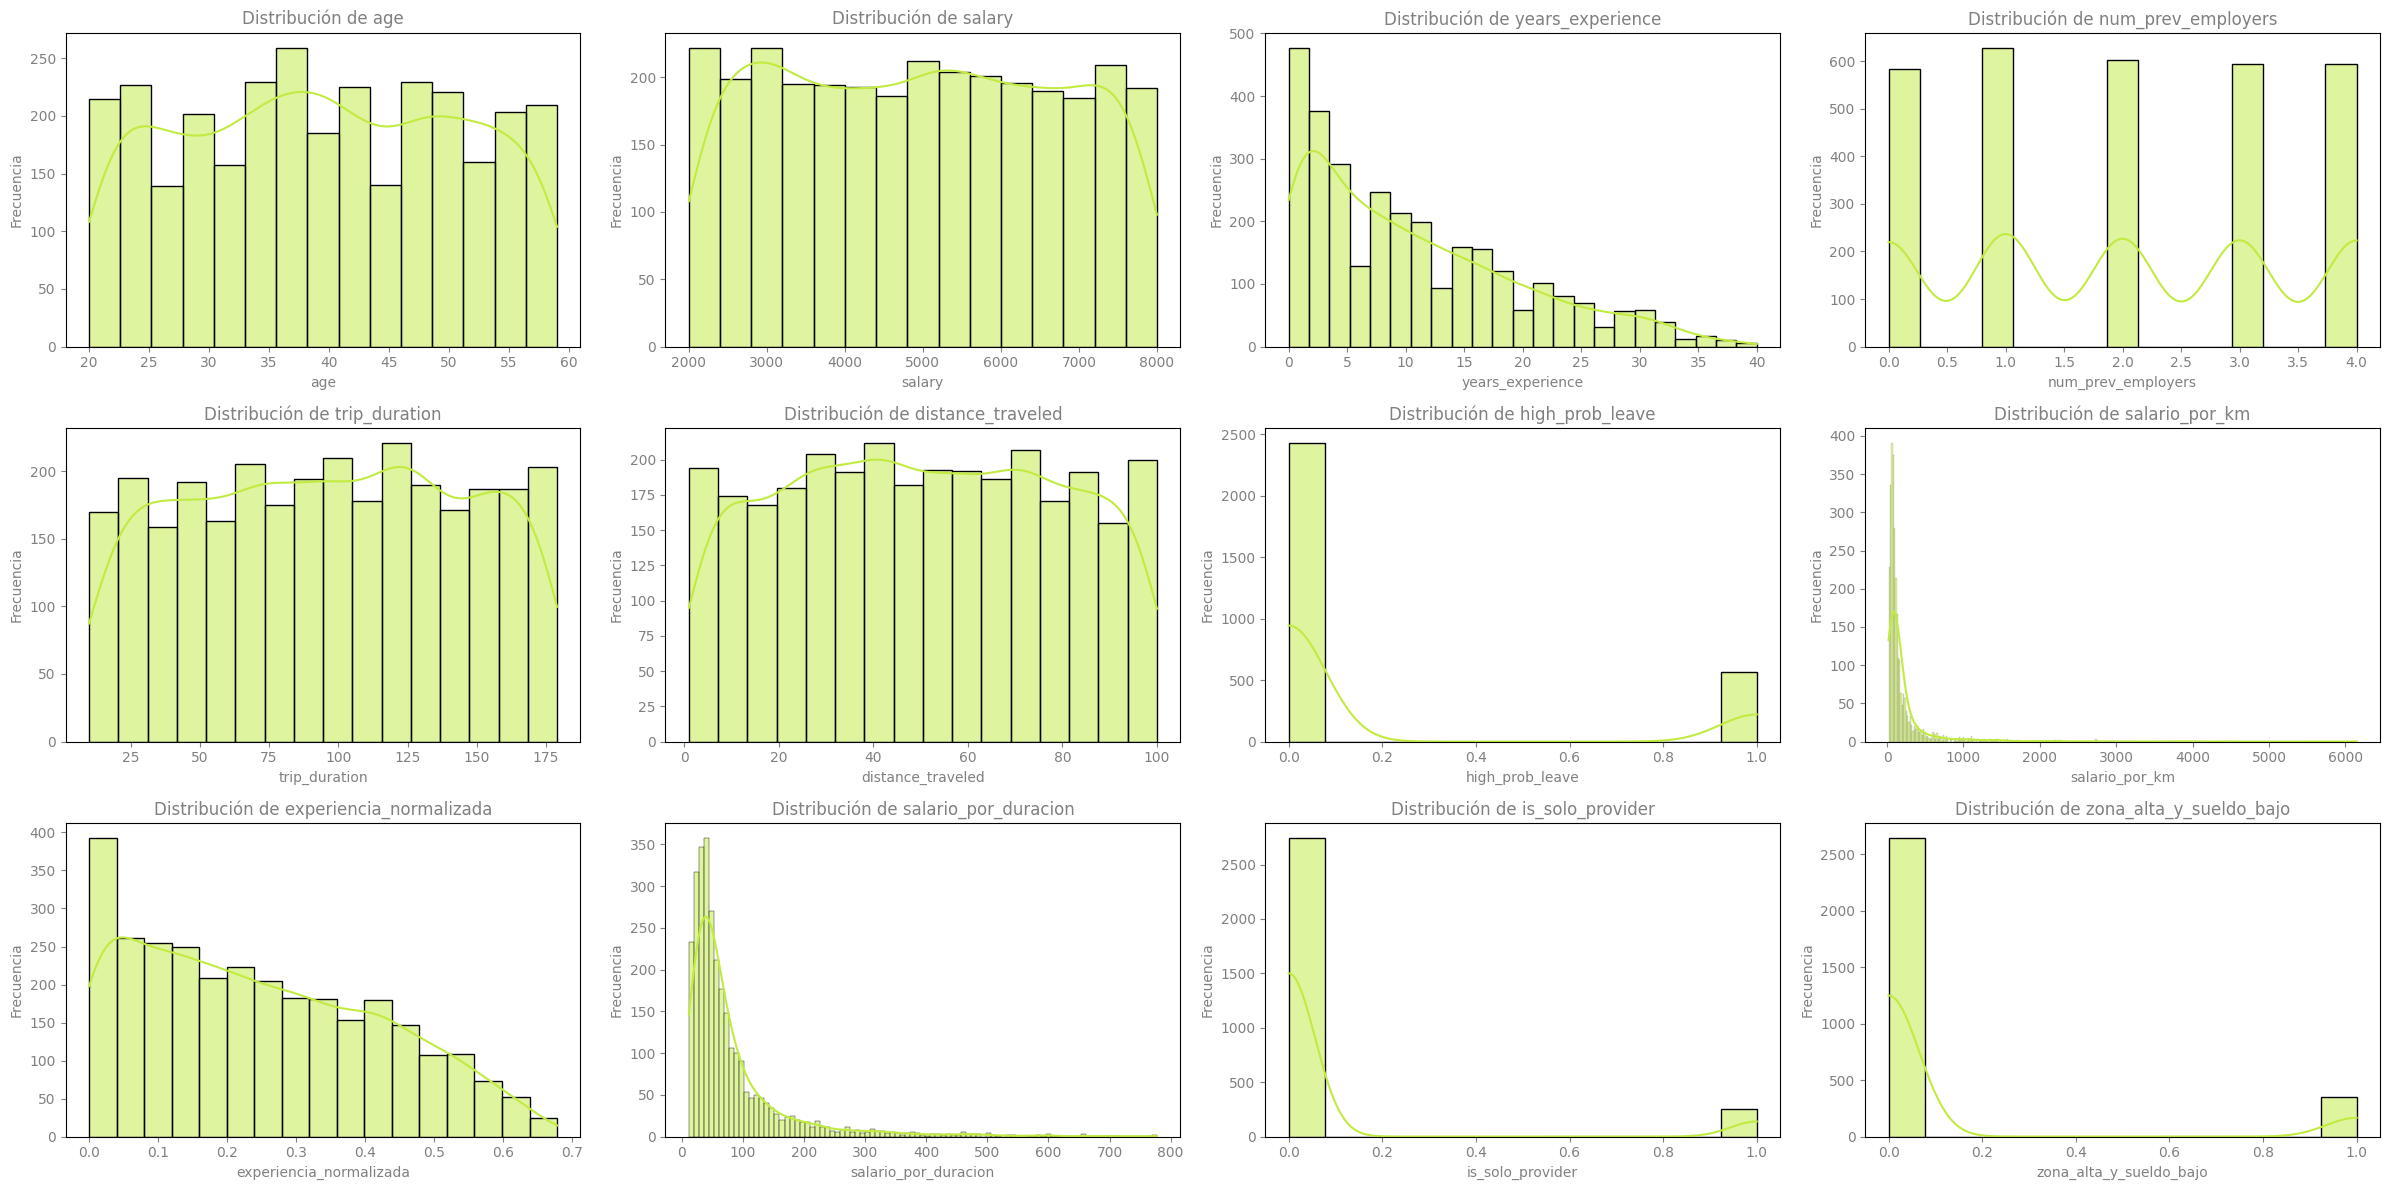

In [ ]:
# Identificar columnas numéricas (excluyendo 'message' y similares)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('driver_id')
print("Columnas numéricas detectadas:", numeric_cols)

# Determinar filas y columnas para los subplots (aquí se usan 2 columnas, ajústalo si lo deseas)
n = len(numeric_cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))
axes = axes.flatten()  # Convertir a una lista unidimensional

# Crear histograma para cada variable numérica en su subplot correspondiente
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color="#c1eb4190")
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar subplots vacíos en caso de que no se usen todos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

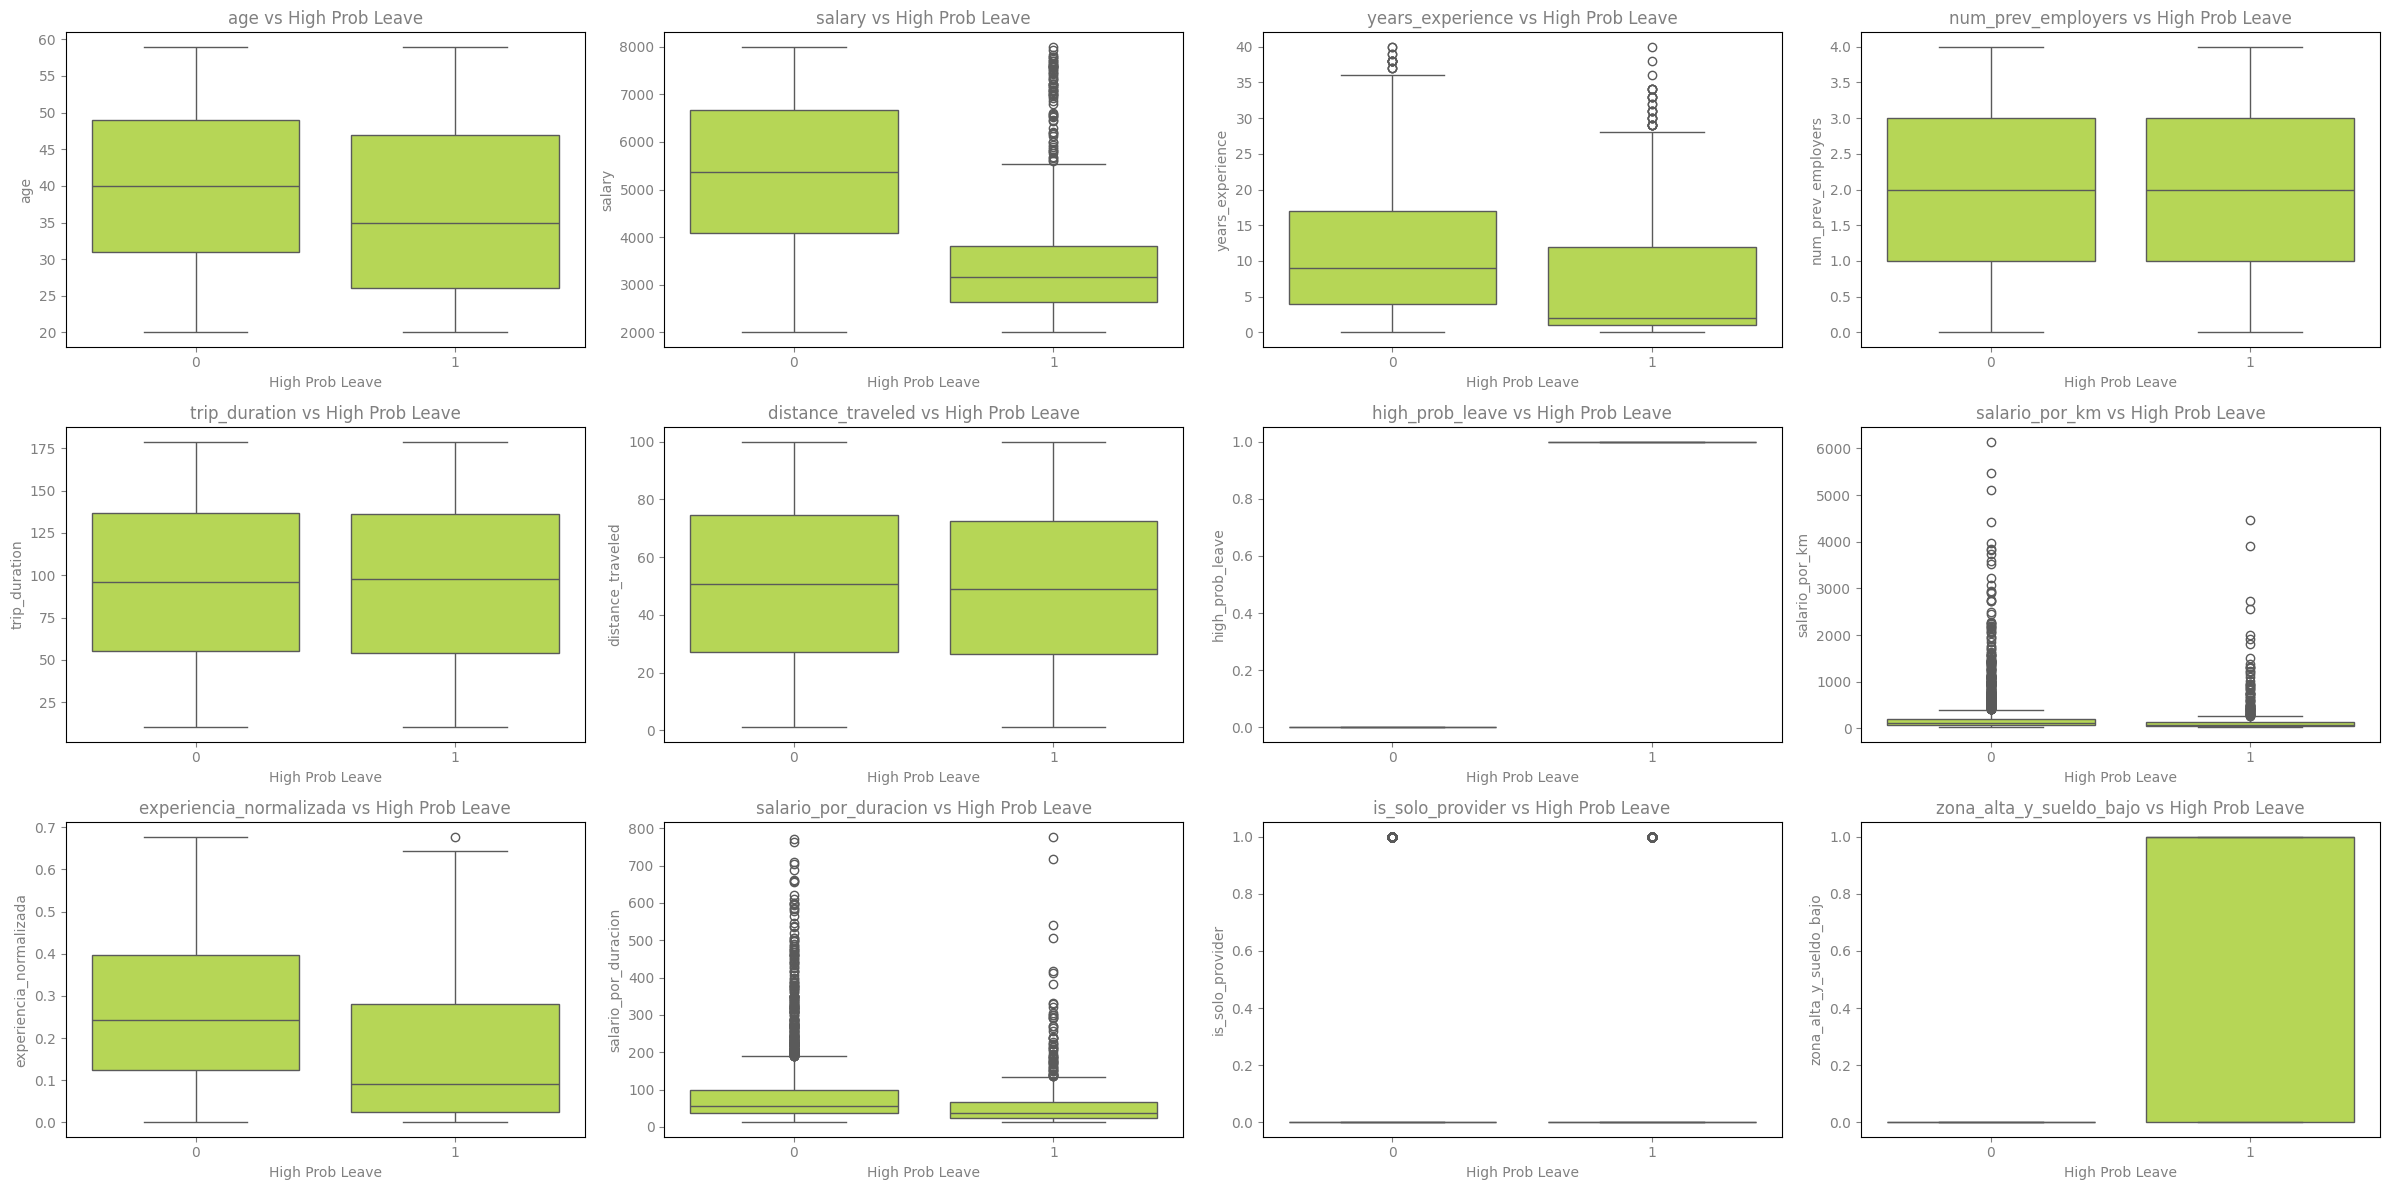

In [ ]:
# Determinar el número de columnas numéricas
n = len(numeric_cols)
ncols = 4  # Puedes ajustar este valor según tu preferencia
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))
axes = axes.flatten()  # Convertir la matriz de ejes en una lista unidimensional

# Crear boxplot para cada variable numérica en su subplot correspondiente
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='high_prob_leave', y=col, data=df, ax=axes[i], color="#c1eb4190")
    axes[i].set_title(f'{col} vs High Prob Leave')
    axes[i].set_xlabel('High Prob Leave')
    axes[i].set_ylabel(col)

# Eliminar subplots vacíos en caso de que existan
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 3. Análisis de la Columna "message"


- **Preprocesamiento del Texto:**
    - *Objetivo:* Limpiar y normalizar el contenido textual eliminando caracteres especiales, convirtiendo a minúsculas, tokenizando y eliminando stopwords.
    - *Lo que se espera encontrar:* Texto estandarizado listo para análisis.
- **Extracción de Características:**
    - *Objetivo:* Transformar el texto en variables numéricas (por ejemplo, TF-IDF, frecuencia de palabras).
    - *Lo que se espera encontrar:* Representaciones cuantitativas que capturen la semántica de los mensajes.
- **Análisis de Sentimientos y Temáticas:**
    - *Objetivo:* Identificar temas y el tono general de los mensajes.
    - *Lo que se espera encontrar:* Patrones que puedan correlacionarse con la probabilidad de renunciar.


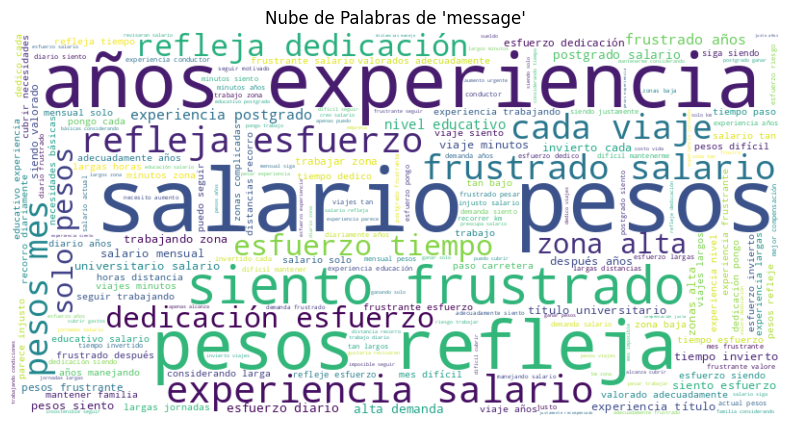

In [ ]:
# Procesamiento del texto en la columna "message"
def preprocess_text(text):
        text = str(text).lower()  # Convertir a minúsculas
        text = re.sub(r'[^a-záéíóúüñ\s]', '', text)  # Eliminar caracteres especiales
        tokens = text.split()
        stop_words = set(stopwords.words('spanish'))
        tokens = [word for word in tokens if word not in stop_words]
        return " ".join(tokens)

df['message_clean'] = df['message'].apply(preprocess_text)

# Generar nube de palabras
all_text = " ".join(df['message_clean'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras de 'message'")
plt.show()

Palabra  Frecuencia
0       salario        2852
1         pesos        2757
2   experiencia        2128
3          años        1803
4      esfuerzo        1572
5       refleja        1343
6     frustrado        1165
7        siento         972
8    dedicación         755
9        tiempo         634
10        viaje         587
11         alta         541
12         cada         533
13         zona         521
14          mes         487
15    postgrado         463
16   frustrante         427
17      minutos         394
18         solo         389
19        zonas         350

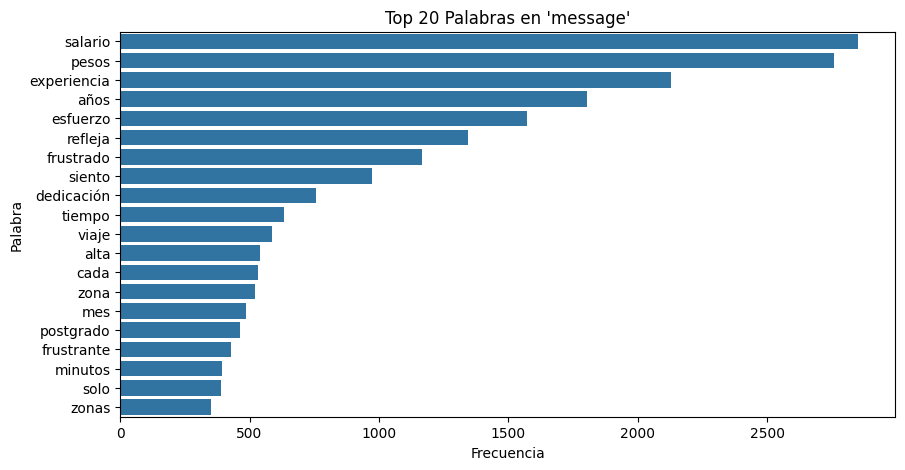

In [ ]:
# Frecuencia de palabras

words = all_text.split()
word_freq = Counter(words)
most_common = word_freq.most_common(20)
common_words_df = pd.DataFrame(most_common, columns=['Palabra', 'Frecuencia'])
display(common_words_df)

# Gráfico de barras para las 20 palabras más frecuentes
plt.figure(figsize=(10,5))
sns.barplot(x='Frecuencia', y='Palabra', data=common_words_df)
plt.title("Top 20 Palabras en 'message'")
plt.show()

# 4. Análisis Multivariado para el Modelo de Renuncia

- **Interacción entre Variables:**
    - *Objetivo:* Examinar relaciones entre variables demográficas, de comportamiento y textuales.
    - *Lo que se espera encontrar:* Interacciones significativas que puedan mejorar la capacidad predictiva del modelo.
- **Análisis de Correlación:**
    - *Objetivo:* Identificar relaciones entre variables numéricas y la variable objetivo ("high_prob_leave").
    - *Lo que se espera encontrar:* Variables con alta correlación que indiquen un mayor riesgo de renuncia.


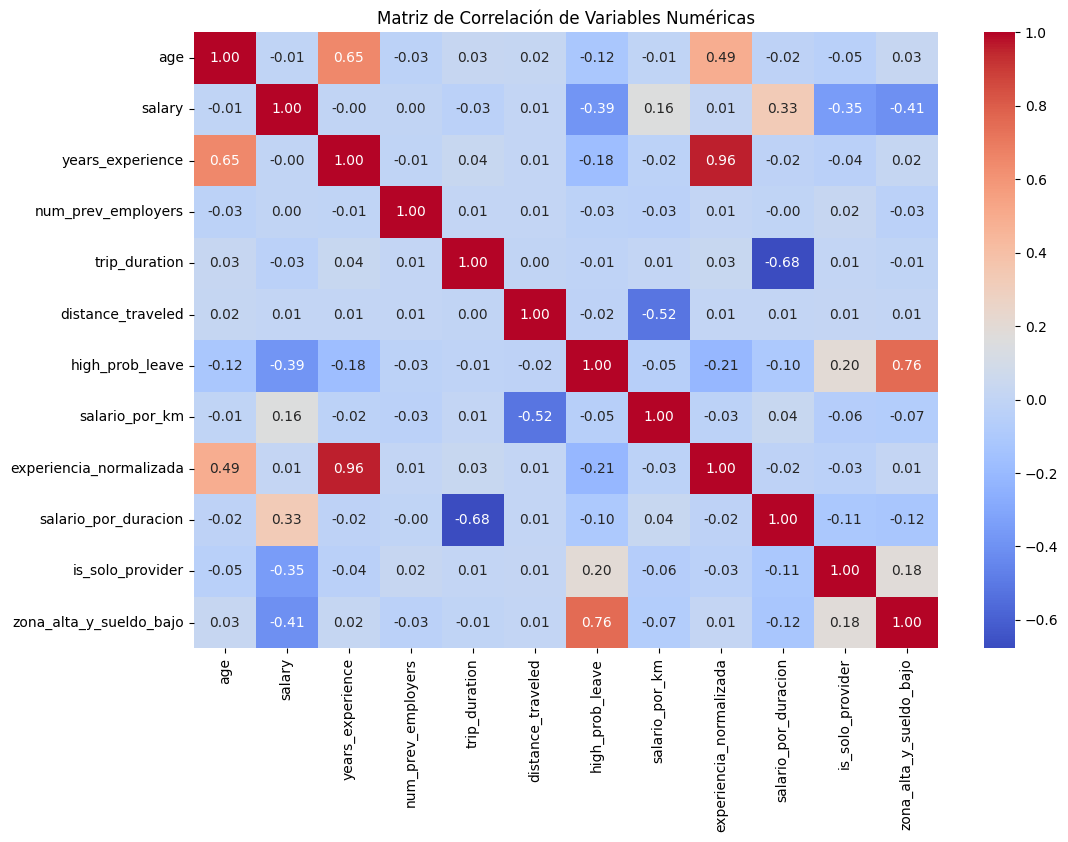

In [ ]:
# Matriz de correlación para variables numéricas
plt.figure(figsize=(12,8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

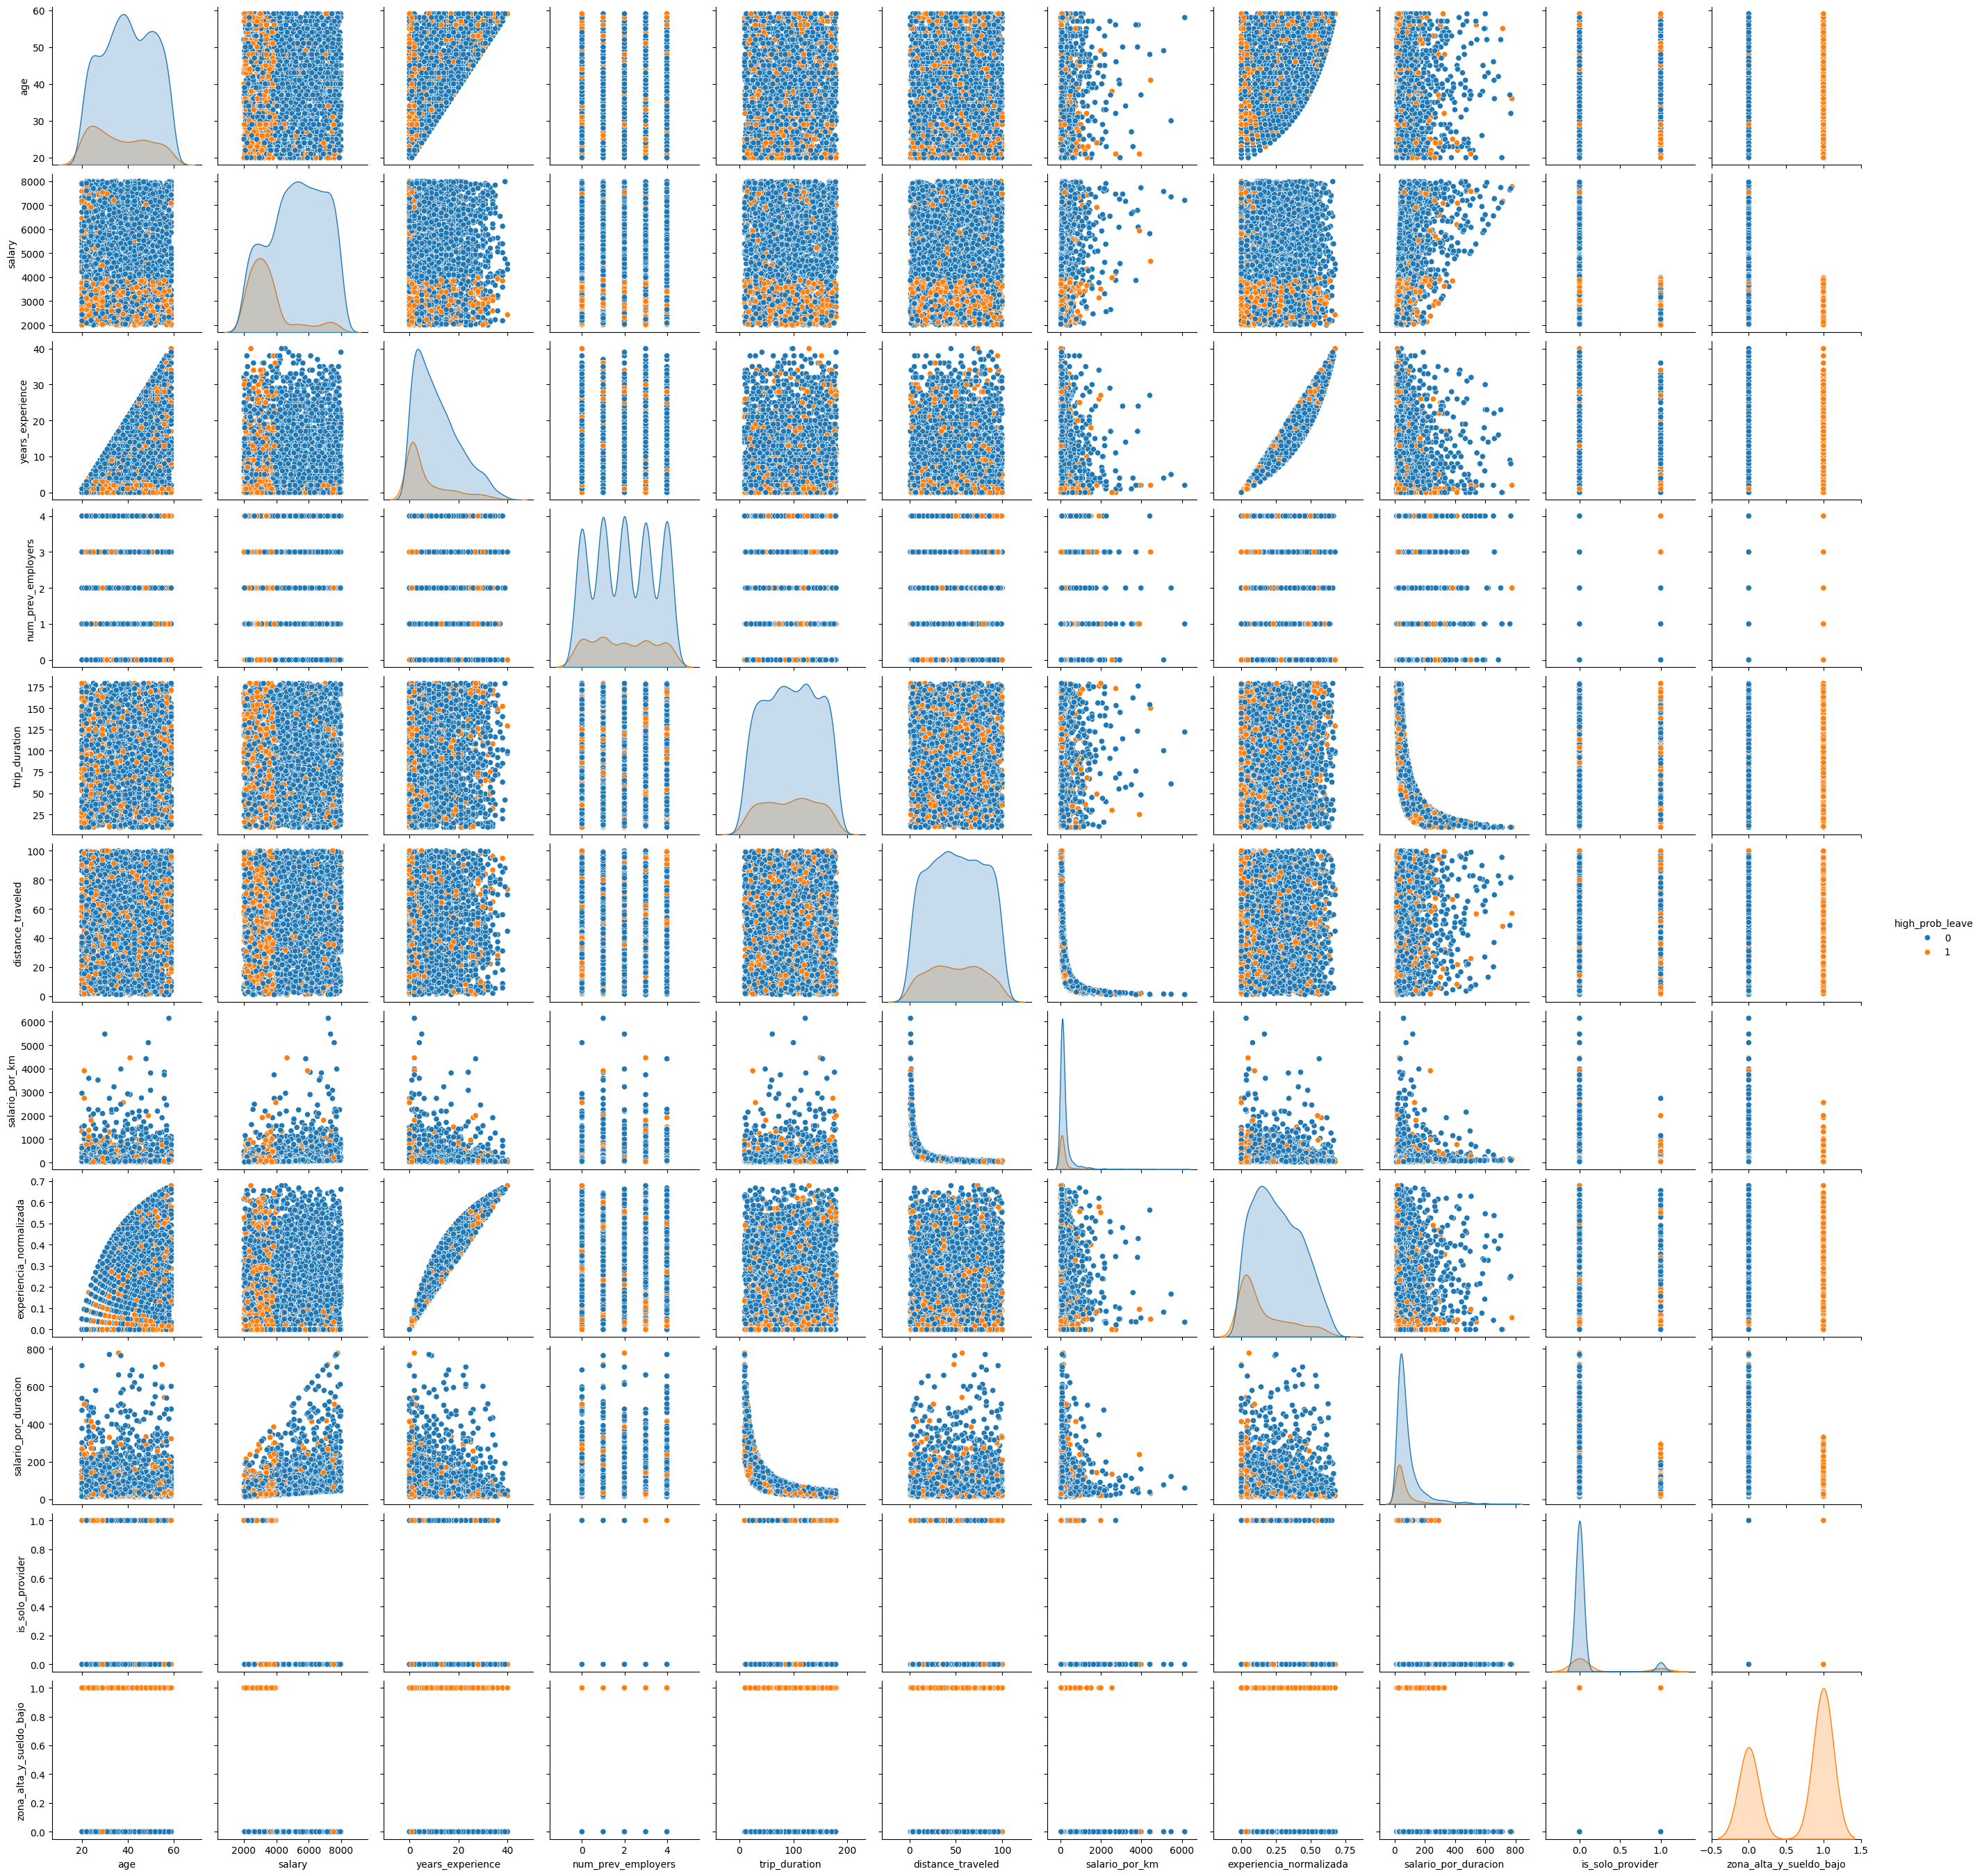

In [ ]:
selected_cols = numeric_cols.copy()
# Se crea un DataFrame temporal para incluir la variable objetivo para el pairplot
df_pair = df[numeric_cols].copy()
df_pair['high_prob_leave'] = df['high_prob_leave']
sns.pairplot(df_pair.dropna(), hue='high_prob_leave')
plt.show()

# 5. Preparación de los Datos para el Modelado

- **Tratamiento de Datos Faltantes y Outliers:**
    - *Objetivo:* Imputar o eliminar valores faltantes y manejar outliers.
    - *Lo que se espera encontrar:* Un dataset limpio y sin valores extremos que afecten el modelado.
- **Escalado y Codificación:**
    - *Objetivo:* Normalizar variables numéricas y codificar variables categóricas para su uso en modelos.
    - *Lo que se espera encontrar:* Datos en un formato adecuado para el entrenamiento de modelos.


In [ ]:
# Tratamiento de valores faltantes para variables numéricas
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Tratamiento de valores faltantes para variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Escalado de variables numéricas
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Codificación de variables categóricas (excluyendo 'message' y 'message_clean')
cols_to_encode = [col for col in categorical_cols if col not in ['message', 'message_clean']]
df_final = pd.get_dummies(df_scaled, columns=cols_to_encode, drop_first=True)


<ipython-input-25-33ad1b357c94>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-25-33ad1b357c94>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

### 6. Relación multivariada entre salario, salario por kilómetro y fuga

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar estilo y colores de texto
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set(rc={
    "text.color": "gray",
    "axes.labelcolor": "gray",
    "xtick.color": "gray",
    "ytick.color": "gray"
})

# Paleta personalizada para hue=0 y hue=1
custom_palette = {
    0: "#c1eb4190",  # Color con transparencia
    1: "#078e1bff"   # Color sin transparencia (alfa=FF)
}

# Pairplot con la nueva paleta
sns.pairplot(
    df[["salary", "salario_por_km", "high_prob_leave"]],
    hue="high_prob_leave",
    palette=custom_palette,
    plot_kws={"alpha": 0.9, "s": 40}
)

# Título de la figura en gris
plt.suptitle("Interacción entre salario, salario_por_km y probabilidad de fuga",
             y=1.02,
             color='gray')

plt.show()

NameError: name 'df' is not defined